In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from from most recent date in database
most_current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_current_date = str(most_current_date)[2:-3]
print(most_current_date)

2017-08-23


In [11]:
year_from_current = str(eval(most_current_date[0:4])-1) + most_current_date[4:]
print(year_from_current)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores & sort the dataframe by date
last_12m_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_from_current).filter(Measurement.date <= most_current_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column  
last_12_prcp_df = pd.DataFrame(data=last_12m_prcp)
last_12_prcp_df.set_index("date", inplace=True)
last_12_prcp_df.rename(columns={"prcp": "precipitation"}, inplace=True)
last_12_prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


<IPython.core.display.Javascript object>


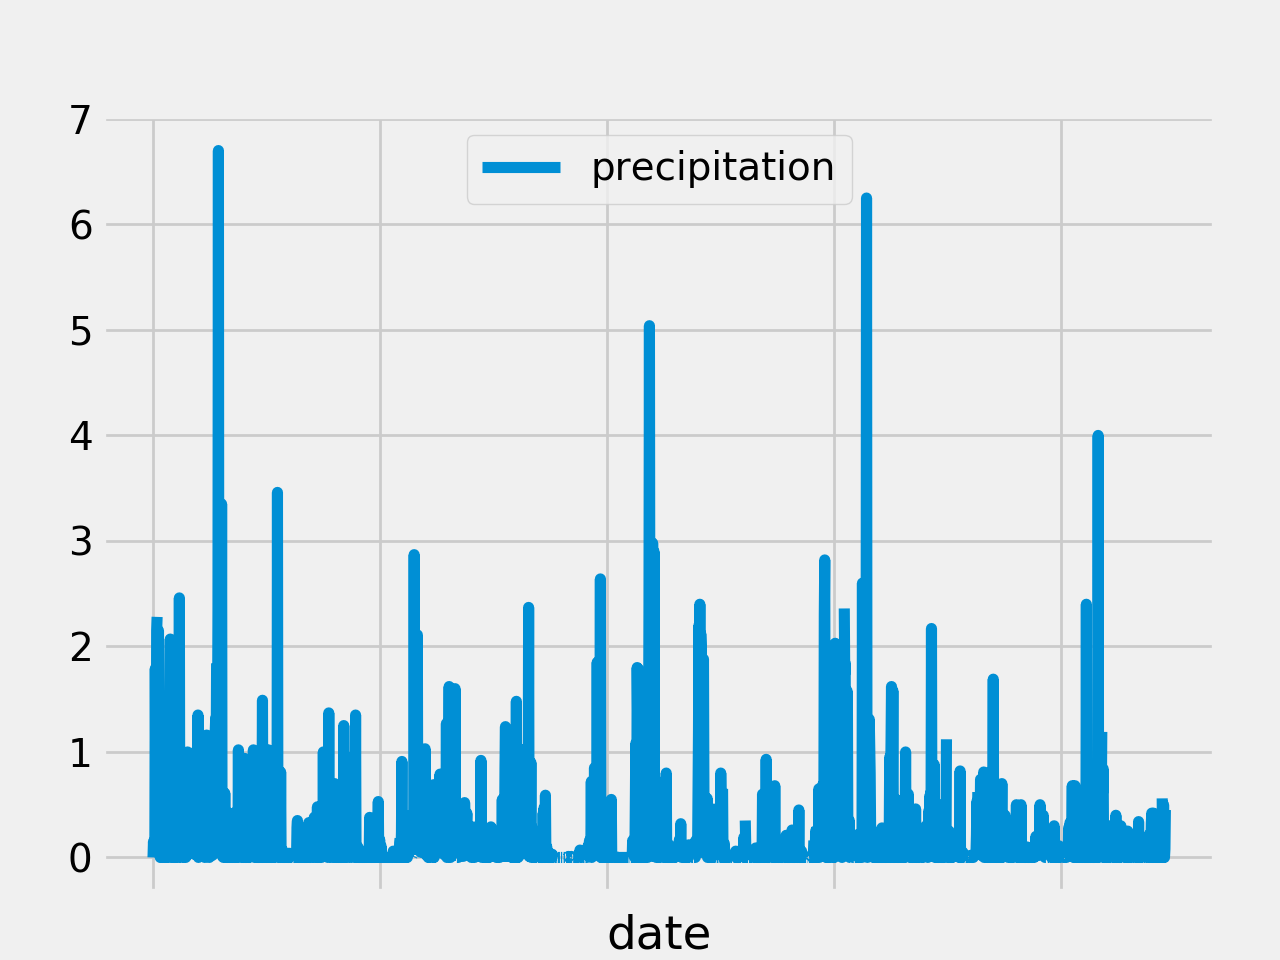

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data & Rotate the xticks for the dates
last_12_prcp_df.plot()
plt.legend(loc=9)
plt.savefig("precipitation_analysis.png")
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [16]:
# What are the most active stations?
observations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

for station in observations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?
top_station = observations[0][0]

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station)
                      
stats_list=list(stats)
print(stats_list)

[(54.0, 85.0, 71.66378066378067)]


<IPython.core.display.Javascript object>


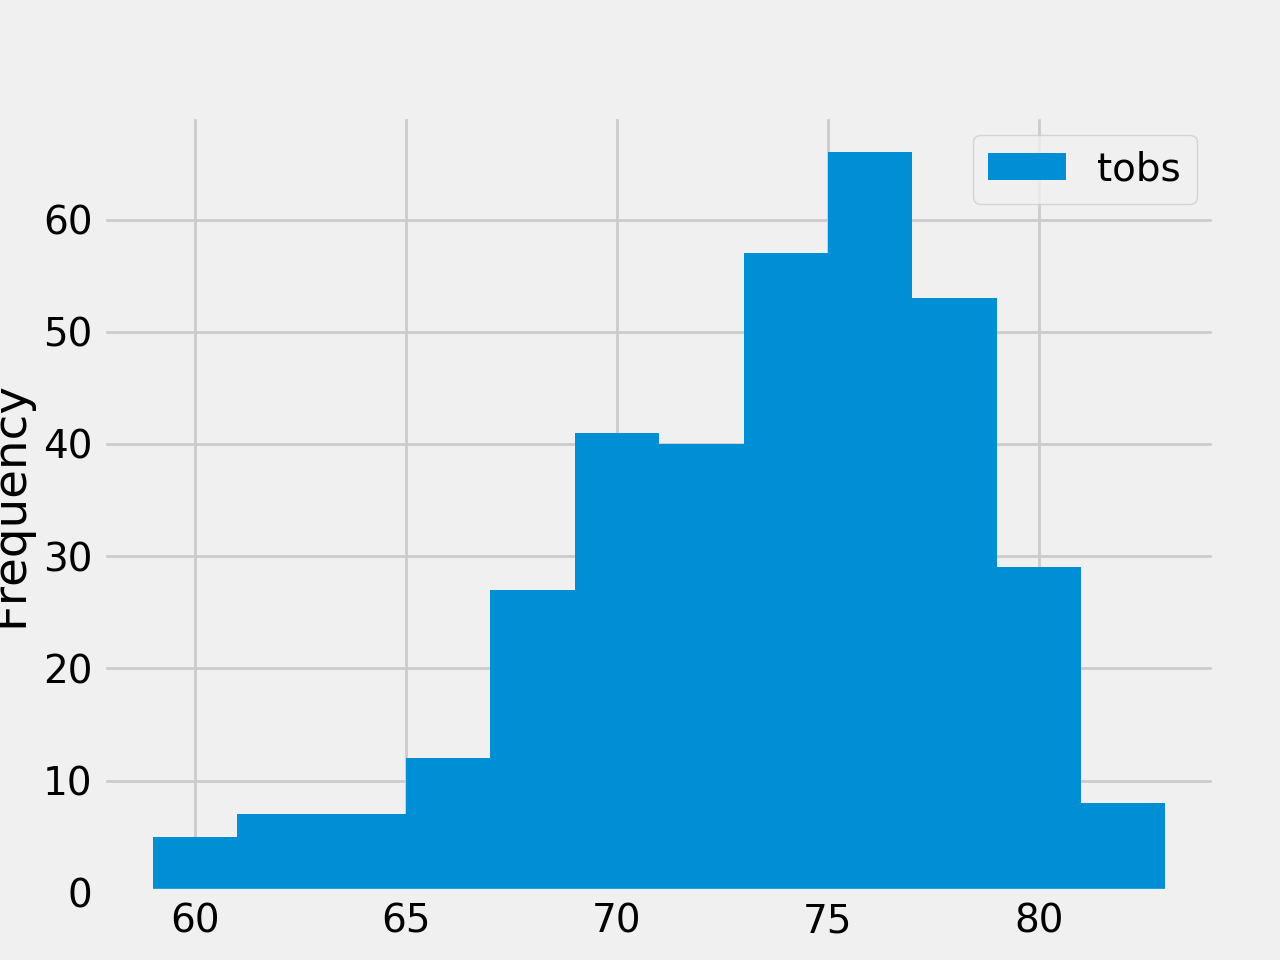

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs = session.query(Measurement.tobs)\
.filter(Measurement.date >= year_from_current)\
.filter(Measurement.date <= most_current_date)\
.filter(Measurement.station == top_station)\

tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
    
fig = plt.figure()
plt.hist(tobs_list, bins=12 , label='tobs')
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.show()
plt.savefig("station_observation_analysis.png")

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

# Define start and end date
start_date = '2012-02-28'
end_date = '2012-03-05'

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps(start_date, end_date))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_year_start = str(eval(start_date[0:4])-1) + start_date[4:]
prev_year_end = str(eval(end_date[0:4])-1) + end_date[4:]

last_year_temp_analysis = calc_temps(prev_year_start, prev_year_end)

tmin = last_year_temp_analysis[0][0]
tmax = last_year_temp_analysis[0][1]
tavg = last_year_temp_analysis[0][2]

print(last_year_temp_analysis)

[(61.0, 69.75510204081633, 75.0)]


<IPython.core.display.Javascript object>


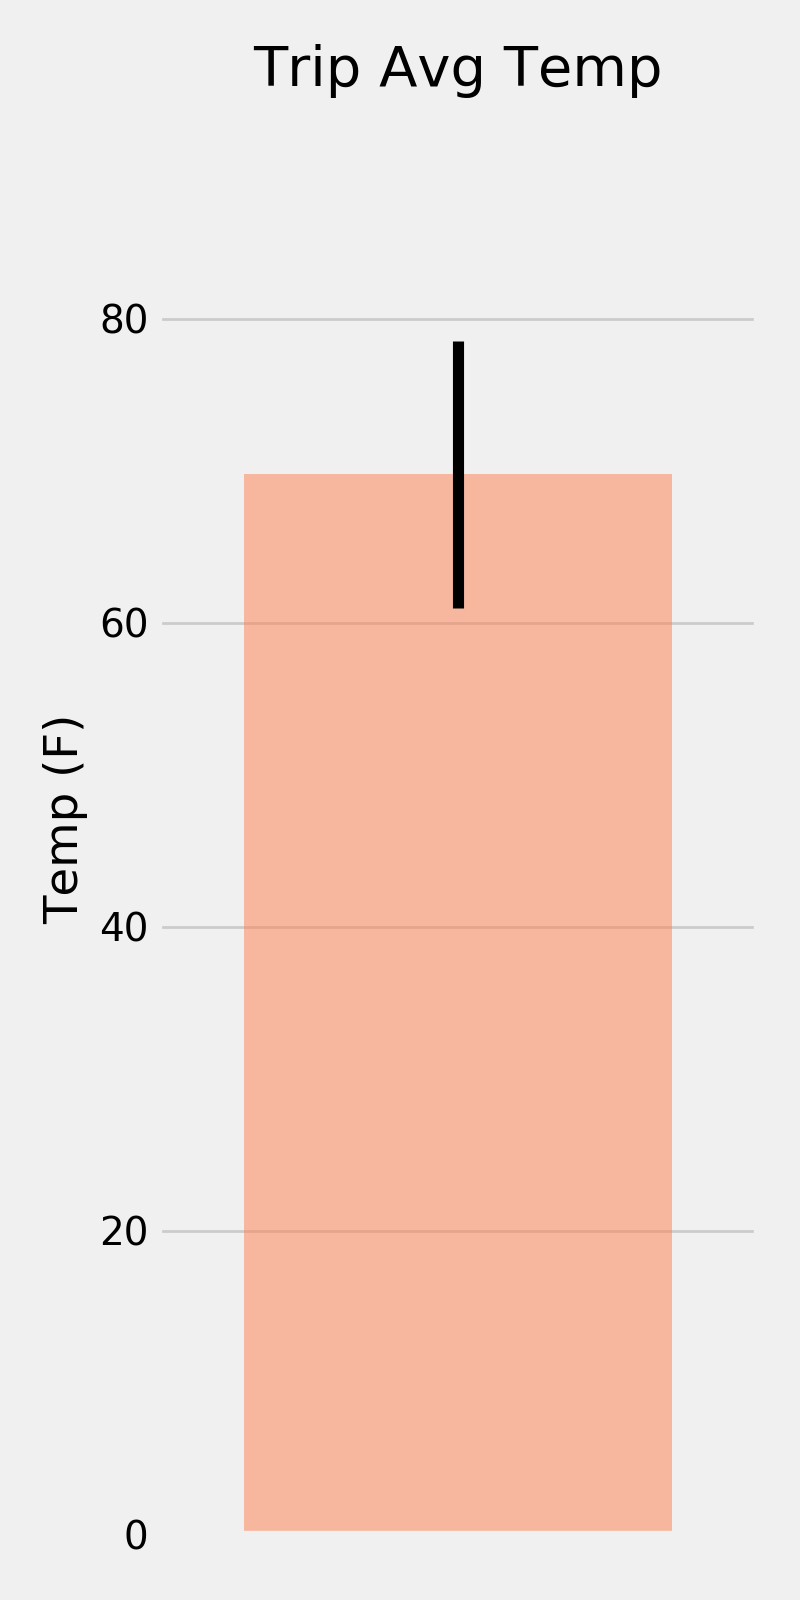

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))

bar= ax.bar(1, tmax, yerr=(tmax-tmin),alpha=0.5, color="coral")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()

plt.savefig("temperature_analysis.png")
plt.show()

In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prcp = session.query(Station.station,Station.name,Station.latitude,Station.longitude,\
                             Station.elevation,func.avg(Measurement.prcp))\
                            .filter(Measurement.station == Station.station)\
                            .filter(Measurement.date >= prev_year_start)\
                            .filter(Measurement.date <= prev_year_end)\
                            .group_by(Station.station)\
                            .order_by(func.sum(Measurement.prcp).desc())

station_prcp_list=list(station_prcp)

print(station_prcp_list)

[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]
